# 利用Python学习线性代数 -- 1.1 线性方程组

本节实现的主要功能函数，在源码文件[linear_system](./linear_system.py)中，后续章节将作为基本功能调用。

## 线性方程
线性方程组由一个或多个线性方程组成，如
$$
\begin{array}\\
x_1 - 2 x_2  &= -1\\
-x_1 + 3 x_2 &= 3
\end{array}
$$

求包含两个变量两个线性方程的方程组的解，等价于求两条直线的交点。
这里可以画出书图1-1和1-2的线性方程组的图形。
通过改变线性方程的参数，观察图形，体会两个方程对应直线平行、相交、重合三种可能。

那么，怎么画二元线性方程的直线呢？

方法是这样的：
假如方程是 $a  x_1 + b x_2 = c$ 的形式，可以写成 $x_2 = (c - a  x_1) / b$。
在以 $x_1$ 和$x_2$为两个轴的直角坐标系中，$x_1$取一组值，如 $(-3, -2.9, -2.8, \dots, 2.9, 3.0)$，
计算相应的 $x_2$，然后把所有点 $(x_1, x_2)$ 连起来成为一条线。
当 $b$ 为 $0$ 时， 则在$x_1 = c / a$处画一条垂直线。

In [1]:
# 引入Numpy和 Matplotlib库
import numpy as np
from matplotlib import pyplot as plt

Matplotlib 是Python中使用较多的可视化库，这里只用到了它的一些基本功能。

In [2]:
def draw_line(a, b, c, start=-4, 
              stop=5, step=0.01):
    """根据线性方程参数绘制一条直线"""
    # 如果b为0，则画一条垂线
    if np.isclose(b, 0):
        plt.vlines(start, stop, c / a)
    else: # 否则画 y = (c - a*x) / b
        xs = np.arange(start, stop, step)
        plt.plot(xs, (c - a*xs)/b)

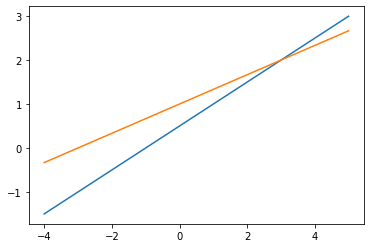

In [3]:
# 1.1 图1-1
draw_line(1, -2, -1)
draw_line(-1, 3, 3)

In [4]:
def draw_lines(augmented, start=-4, 
              stop=5, step=0.01):
    """给定增广矩阵，画两条线."""
    plt.figure()
    for equation in augmented:
        draw_line(*equation, start, stop, step)
    plt.show()

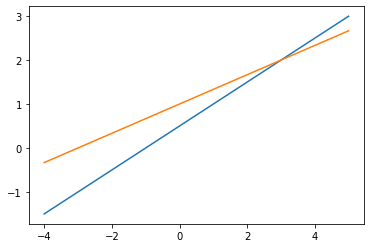

In [5]:
# Fig. 1-1
# 增广矩阵用二维数组表示 
# [[1, -2, -1], [-1, 3, 3]]
# 这些数字对应图1-1对应方程的各项系数
draw_lines([[1, -2, -1], [-1, 3, 3]])

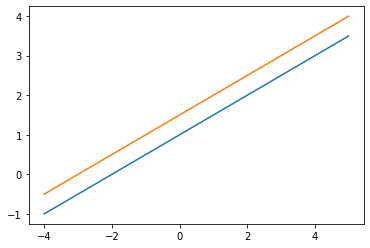

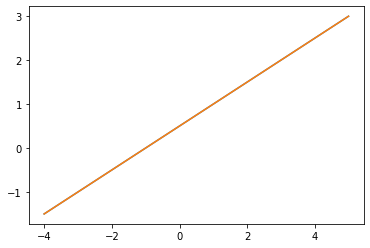

In [6]:
# Fig. 1-2
draw_lines([[1, -2, -2], [-1, 2, 3]])
# Fig. 1-3
draw_lines([[1, -2, -1], [-1, 2, 1]])

* 建议：改变这些系数，观察直线，体会两条直线相交、平行和重合的情况

例如
```
draw_lines([[1, -2, -2], [-1, 2, 9]])
```

如果对Numpy比较熟悉，则可以采用更简洁的方式实现上述绘图功能。
在计算多条直线方程时，可以利用向量编程的方式，用更少的代码实现。

In [7]:
def draw_lines(augmented, start=-4, 
               stop=5, step=0.01):
    """Draw lines represented by augmented matrix on 2-d plane."""
    am = np.asarray(augmented)
    xs = np.arange(start, stop, step).reshape([1, -1])
    # 同时计算两条直线的y值
    ys = (am[:, [-1]] - am[:, [1]]*xs) / am[:, [0]]
    for y in ys:
        plt.plot(xs[0], y)
    plt.show()

## 矩阵记号
矩阵是一个数表，在程序中通常用二维数组表示，例如

In [8]:
# 嵌套列表表示矩阵
matrix = [[1, -2, 1, 0],
          [0, 2, -8, 8],
          [5, 0, -5, 10]]
matrix

[[1, -2, 1, 0], [0, 2, -8, 8], [5, 0, -5, 10]]

实际工程和研究实践中，往往会采用一些专门的数值计算库，简化和加速计算。
Numpy库是Python中数值计算的常用库。
在Numpy中，多维数组类型称为ndarray，可以理解为n dimensional array。
例如

In [9]:
# Numpy ndarray 表示矩阵
matrix = np.array([[1, -2, 1, 0],
                    [0, 2, -8, 8],
                    [5, 0, -5, 10]])
matrix

array([[ 1, -2,  1,  0],
       [ 0,  2, -8,  8],
       [ 5,  0, -5, 10]])

## 解线性方程组
本节解线性方程组的方法是 **高斯消元法**，利用了三种基本行变换。

1. 把某个方程换成它与另一个方程的倍数的和；
2. 交换两个方程的位置；
3. 某个方程的所有项乘以一个非零项。

假设线性方程的增广矩阵是$A$，其第$i$行$j$列的元素是$a_{ij}$。
消元法的基本步骤是：
* 增广矩阵中有 $n$ 行，该方法的每一步处理一行。
    1. 在第$i$步，该方法处理第$i$行
        * 若$a_{ii}$为0，则在剩余行 $\{j| j \in (i, n]\}$中选择绝对值最大的行$a_{ij}$
            * 若$a_{ij}$为0，返回第1步。
            * 否则利用变换2，交换$A$的第$i$和$j$行。
    2. 利用行变换3，第$i$行所有元素除以$a_{ii}$，使第 $i$ 个方程的第 $i$个 系数为1
    3. 利用行变换1，$i$之后的行减去第$i$行的倍数，使这些行的第 $i$ 列为0

为了理解这些步骤的实现，这里先按书中的例1一步步计算和展示，然后再总结成完整的函数。
例1的增广矩阵是

$$
\left[
\begin{array}
&1 & -2 & 1 & 0\\
0 & 2 & -8 & 8\\
5 & 0 & -5 & 10 
\end{array}
\right]
$$

In [10]:
# 增广矩阵
A = np.array([[1, -2, 1, 0],
              [0, 2, -8, 8],
              [5, 0, -5, 10]])
# 行号从0开始，处理第0行
i = 0
# 利用变换3，将第i行的 a_ii 转成1。这里a_00已经是1，所不用动
# 然后利用变换1，把第1行第0列，第2行第0列都减成0。
# 这里仅需考虑i列之后的元素，因为i列之前的元素已经是0
#   即第1行减去第0行的0倍
#   而第2行减去第0行的5倍
A[i+1:, i:] = A[i+1:, i:] - A[i+1:, [i]] * A[i, i:]
A

array([[  1,  -2,   1,   0],
       [  0,   2,  -8,   8],
       [  0,  10, -10,  10]])

In [11]:
i = 1
# 利用变换3，将第i行的 a_ii 转成1。
A[i] = A[i] / A[i, i]
A

array([[  1,  -2,   1,   0],
       [  0,   1,  -4,   4],
       [  0,  10, -10,  10]])

In [12]:
# 然后利用变换1，把第2行第i列减成0。
A[i+1:, i:] = A[i+1:, i:] - A[i+1:, [i]] * A[i, i:]
A

array([[  1,  -2,   1,   0],
       [  0,   1,  -4,   4],
       [  0,   0,  30, -30]])

In [13]:
i = 2
# 利用变换3，将第i行的 a_ii 转成1。
A[i] = A[i] / A[i, i]
A

array([[ 1, -2,  1,  0],
       [ 0,  1, -4,  4],
       [ 0,  0,  1, -1]])

消元法的前向过程就结束了，我们可以总结成一个函数

In [14]:
def eliminate_forward(augmented): 
    """
    消元法的前向过程.
    
    返回行阶梯形，以及先导元素的坐标（主元位置）
    """
    A = np.asarray(augmented, dtype=np.float64)
    # row number of the last row
    pivots = []
    i, j = 0, 0
    while i < A.shape[0] and j < A.shape[1]:
        A[i] = A[i] / A[i, j]
        if (i + 1) < A.shape[0]: # 除最后一行外
            A[i+1:, j:] = A[i+1:, j:] - A[i+1:, [j]] * A[i, j:]
        pivots.append((i, j))
        i += 1
        j += 1
    return A, pivots

这里有两个细节值得注意
1. 先导元素 $a_{ij}$，不一定是在主对角线位置，即 $i$ 不一定等于$j$.
2. 最后一行只需要用变换3把先导元素转为1，没有剩余行需要转换

In [15]:
# 测试一个增广矩阵，例1
A = np.array([[1, -2, 1, 0],
              [0, 2, -8, 8],
              [5, 0, -5, 10]])
A, pivots = eliminate_forward(A)
print(A)
print(pivots)

[[ 1. -2.  1.  0.]
 [ 0.  1. -4.  4.]
 [ 0.  0.  1. -1.]]
[(0, 0), (1, 1), (2, 2)]


消元法的后向过程则更简单一些，对于每一个主元(这里就是前面的$a_{ii}$)，将其所在的列都用变换1，使其它行对应的列为0.

In [16]:
for i, j in reversed(pivots):
    A[:i, j:] = A[:i, j:] - A[[i], j:] * A[:i, [j]] 
A

array([[ 1.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1., -1.]])

In [17]:
def eliminate_backward(simplified, pivots):
    """消元法的后向过程."""
    A = np.asarray(simplified)
    for i, j in reversed(pivots):
        A[:i, j:] = A[:i, j:] - A[[i], j:] * A[:i, [j]] 
    return A

至此，结合 eliminate_forward 和eliminate_backward函数，可以解形如例1的线性方程。

然而，存在如例3的线性方程，在eliminate_forward算法进行的某一步，主元为0，需要利用变换2交换两行。
交换行时，可以选择剩余行中，选择当前主元列不为0的任意行，与当前行交换。
这里每次都采用剩余行中，当前主元列绝对值最大的行。
补上行交换的前向过程函数如下

In [18]:
def eliminate_forward(augmented): 
    """消元法的前向过程"""
    A = np.asarray(augmented, dtype=np.float64)
    # row number of the last row
    pivots = []
    i, j = 0, 0
    while i < A.shape[0] and j < A.shape[1]:
        # if pivot is zero, exchange rows
        if np.isclose(A[i, j], 0):
            if (i + 1) < A.shape[0]:
                max_k = i + 1 + np.argmax(np.abs(A[i+1:, i]))
            if (i + 1) >= A.shape[0] or np.isclose(A[max_k, i], 0):
                j += 1
                continue
            A[[i, max_k]] = A[[max_k, i]]
        A[i] = A[i] / A[i, j]
        if (i + 1) < A.shape[0]:
            A[i+1:, j:] = A[i+1:, j:] - A[i+1:, [j]] * A[i, j:]
        pivots.append((i, j))
        i += 1
        j += 1
    return A, pivots

行交换时，有一种特殊情况，即**剩余所有行的主元列都没有非零元素**。
这种情况下，在当前列的右侧寻找不为零的列，作为新的主元列。

In [19]:
# 用例3测试eliminate_forward
aug = [[0, 1, -4, 8],
       [2, -3, 2, 1],
       [4, -8, 12, 1]]
echelon, pivots = eliminate_forward(aug)
print(echelon)
print(pivots)

[[ 1.   -2.    3.    0.25]
 [ 0.    1.   -4.    0.5 ]
 [ 0.    0.    0.    1.  ]]
[(0, 0), (1, 1), (2, 3)]


例3化简的结果与书上略有不同，由行交换策略不同引起，也说明同一个矩阵可能由多个阶梯形。

结合上述的前向和后向过程，即可以给出一个完整的消元法实现

In [20]:
def eliminate(augmented):
    """
    利用消元法前向和后向步骤，化简线性方程组.
    
    如果是矛盾方程组，则仅输出前向化简结果，并打印提示
    否则输出简化后的方程组，并输出最后一列
    """
    print(np.asarray(augmented))
    A, pivots = eliminate_forward(augmented)
    print(" The echelon form is\n", A)
    print(" The pivots are: ", pivots)
    pivot_cols = {p[1] for p in pivots}
    simplified = eliminate_backward(A, pivots)
    if (A.shape[1]-1) in pivot_cols:
        print(" There is controdictory.\n", simplified)
    elif len(pivots) == (A.shape[1] -1):
        print(" Solution: ", simplified[:, -1])
        is_correct = solution_check(np.asarray(augmented), 
                            simplified[:, -1])
        print(" Is the solution correct? ", is_correct)
    else:
        print(" There are free variables.\n", simplified)
    print("-"*30)

In [21]:
eliminate(aug)

[[ 0  1 -4  8]
 [ 2 -3  2  1]
 [ 4 -8 12  1]]
 The echelon form is
 [[ 1.   -2.    3.    0.25]
 [ 0.    1.   -4.    0.5 ]
 [ 0.    0.    0.    1.  ]]
 The pivots are:  [(0, 0), (1, 1), (2, 3)]
 There is controdictory.
 [[ 1.  0. -5.  0.]
 [ 0.  1. -4.  0.]
 [ 0.  0.  0.  1.]]
------------------------------


## 利用 Sympy 验证消元法实现的正确性
Python的符号计算库Sympy，有化简矩阵为行最简型的方法，可以用来检验本节实现的代码是否正确。

In [22]:
# 导入 sympy的 Matrix模块
from sympy import Matrix

In [23]:
Matrix(aug).rref(simplify=True)
# 返回的是行最简型和主元列的位置

(Matrix([
 [1, 0, -5, 0],
 [0, 1, -4, 0],
 [0, 0,  0, 1]]), (0, 1, 3))

In [24]:
echelon, pivots = eliminate_forward(aug)
simplified = eliminate_backward(echelon, pivots)
print(simplified, pivots)
# 输出与上述rref一致

[[ 1.  0. -5.  0.]
 [ 0.  1. -4.  0.]
 [ 0.  0.  0.  1.]] [(0, 0), (1, 1), (2, 3)]


## 综合前向和后向步骤，并结果的正确性
综合前向和后向消元，就可以得到完整的消元法过程。
消元结束，如果没有矛盾（最后一列不是主元列），基本变量数与未知数个数一致，则有唯一解，可以验证解是否正确。
验证的方法是将解与系数矩阵相乘，检查与原方程的b列一致。

In [25]:
def solution_check(augmented, solution):
    # 系数矩阵与解相乘
    b = augmented[:, :-1] @ solution.reshape([-1, 1])
    b = b.reshape([-1])
    # 检查乘积向量与b列一致
    return all(np.isclose(b - augmented[:, -1], np.zeros(len(b))))

In [26]:
def eliminate(augmented):
    from sympy import Matrix
    print(np.asarray(augmented))
    A, pivots = eliminate_forward(augmented)
    print(" The echelon form is\n", A)
    print(" The pivots are: ", pivots)
    pivot_cols = {p[1] for p in pivots}
    simplified = eliminate_backward(A, pivots)
    if (A.shape[1]-1) in pivot_cols: # 最后一列是主元列
        print(" There is controdictory.\n", simplified)
    elif len(pivots) == (A.shape[1] -1): # 唯一解
        is_correct = solution_check(np.asarray(augmented), 
                            simplified[:, -1])
        print(" Is the solution correct? ", is_correct)
        print(" Solution: \n", simplified)
    else: # 有自由变量
        print(" There are free variables.\n", simplified)
    print("-"*30)
    print("对比Sympy的rref结果")
    print(Matrix(augmented).rref(simplify=True))
    print("-"*30)

测试书中的例子

In [27]:
aug_1_1_1 = [[1, -2, 1, 0], 
             [0, 2, -8, 8], 
             [5, 0, -5, 10]]
eliminate(aug_1_1_1)
# 1.1 example 3
aug_1_1_3 = [[0, 1, -4, 8],
             [2, -3, 2, 1],
             [4, -8, 12, 1]]
eliminate(aug_1_1_3)
eliminate([[1, -6, 4, 0, -1],
           [0, 2, -7, 0, 4],
           [0, 0, 1, 2, -3],
           [0, 0, 3, 1, 6]])
eliminate([[0, -3, -6, 4, 9],
           [-1, -2, -1, 3, 1],
           [-2, -3, 0, 3, -1],
           [1, 4, 5, -9, -7]])

eliminate([[0, 3, -6, 6, 4, -5],
           [3, -7, 8, -5, 8, 9],
           [3, -9, 12, -9, 6, 15]])

[[ 1 -2  1  0]
 [ 0  2 -8  8]
 [ 5  0 -5 10]]
 The echelon form is
 [[ 1. -2.  1.  0.]
 [ 0.  1. -4.  4.]
 [ 0.  0.  1. -1.]]
 The pivots are:  [(0, 0), (1, 1), (2, 2)]
 Is the solution correct?  True
 Solution: 
 [[ 1.  0.  0.  1.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1. -1.]]
------------------------------
对比Sympy的rref结果
(Matrix([
[1, 0, 0,  1],
[0, 1, 0,  0],
[0, 0, 1, -1]]), (0, 1, 2))
------------------------------
[[ 0  1 -4  8]
 [ 2 -3  2  1]
 [ 4 -8 12  1]]
 The echelon form is
 [[ 1.   -2.    3.    0.25]
 [ 0.    1.   -4.    0.5 ]
 [ 0.    0.    0.    1.  ]]
 The pivots are:  [(0, 0), (1, 1), (2, 3)]
 There is controdictory.
 [[ 1.  0. -5.  0.]
 [ 0.  1. -4.  0.]
 [ 0.  0.  0.  1.]]
------------------------------
对比Sympy的rref结果
(Matrix([
[1, 0, -5, 0],
[0, 1, -4, 0],
[0, 0,  0, 1]]), (0, 1, 3))
------------------------------
[[ 1 -6  4  0 -1]
 [ 0  2 -7  0  4]
 [ 0  0  1  2 -3]
 [ 0  0  3  1  6]]
 The echelon form is
 [[ 1.  -6.   4.   0.  -1. ]
 [ 0.   1.  -3.5  0.   2. ]
 [ 0.   0.